In [1]:
!pip install gdown

import gdown

file_id = "1vbMFTe2E5OHp2h5o_YL-RUoIFKxsrZWT"
url = f"https://drive.google.com/uc?id={file_id}"

output = "bottlecap_dataset.zip"
gdown.download(url, output, quiet=False)

print("Download selesai:", output)


Downloading...
From: https://drive.google.com/uc?id=1vbMFTe2E5OHp2h5o_YL-RUoIFKxsrZWT
To: /content/bottlecap_dataset.zip
100%|██████████| 594k/594k [00:00<00:00, 105MB/s]

Download selesai: bottlecap_dataset.zip


In [2]:
import os, zipfile

zip_path = "bottlecap_dataset.zip"
extract_folder = "bottlecap_dataset"

os.makedirs(extract_folder, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"File berhasil diekstrak ke folder: {extract_folder}")


File berhasil diekstrak ke folder: bottlecap_dataset


In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.9 MB/s eta 0:00:00


In [4]:
import cv2
import numpy as np
from pathlib import Path
import shutil

ROOT = Path("bottlecap_dataset/sample")
OUT_IMG = Path("yolo_dataset/images")
OUT_LBL = Path("yolo_dataset/labels")

OUT_IMG.mkdir(parents=True, exist_ok=True)
OUT_LBL.mkdir(parents=True, exist_ok=True)

CLASS_MAP = {
    'light_blue': 0,
    'dark_blue': 1,
    'others': 2
}

def classify_color(img, box):
    h, w = img.shape[:2]
    xc, yc, bw, bh = box

    x1 = int((xc - bw/2) * w)
    y1 = int((yc - bh/2) * h)
    x2 = int((xc + bw/2) * w)
    y2 = int((yc + bh/2) * h)

    crop = img[max(0,y1):min(h,y2), max(0,x1):min(w,x2)]
    if crop.size == 0:
        return "others"

    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)

    # Range biru diperluas
    lower_blue = np.array([75, 40, 40])
    upper_blue = np.array([150, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    ratio = np.count_nonzero(mask) / mask.size

    if ratio > 0.02:  # fix: 2% cukup
        mean_v = np.mean(hsv[:,:,2][mask > 0])
        return "light_blue" if mean_v > 100 else "dark_blue"

    return "others"


# -----------------------
# Proses semua file
# -----------------------
processed = 0

for file in ROOT.iterdir():
    if file.suffix.lower() == ".jpg":
        img = cv2.imread(str(file))
        label_file = ROOT / (file.stem + ".txt")
        if not label_file.exists():
            continue

        new_lines = []

        with open(label_file, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                _, xc, yc, bw, bh = parts
                box = [float(xc), float(yc), float(bw), float(bh)]

                cls = classify_color(img, box)
                cls_id = CLASS_MAP[cls]

                new_lines.append(f"{cls_id} {xc} {yc} {bw} {bh}\n")

        shutil.copy(str(file), OUT_IMG / file.name)

        with open(OUT_LBL / (file.stem + ".txt"), "w") as f:
            f.writelines(new_lines)

        processed += 1
        print(f"Diproses: {processed} → {file.name}")

print("\nSelesai re-labeling warna! 🎉")


Diproses: 1 → raw-250110_dc_s001_b3_4.jpg
Diproses: 2 → raw-250110_dc_s001_b5_3.jpg
Diproses: 3 → raw-250110_dc_s001_b4_3.jpg
Diproses: 4 → raw-250110_dc_s001_b5_2.jpg
Diproses: 5 → raw-250110_dc_s001_b4_1.jpg
Diproses: 6 → raw-250110_dc_s001_b3_2.jpg
Diproses: 7 → raw-250110_dc_s001_b2_1.jpg
Diproses: 8 → raw-250110_dc_s001_b4_2.jpg
Diproses: 9 → raw-250110_dc_s001_b2_3.jpg
Diproses: 10 → raw-250110_dc_s001_b5_5.jpg
Diproses: 11 → raw-250110_dc_s001_b3_3.jpg
Diproses: 12 → raw-250110_dc_s001_b2_15.jpg

Selesai re-labeling warna! 🎉


In [5]:
import albumentations as A

OUT_IMG_AUG = Path("yolo_dataset_aug/images")
OUT_LBL_AUG = Path("yolo_dataset_aug/labels")

OUT_IMG_AUG.mkdir(parents=True, exist_ok=True)
OUT_LBL_AUG.mkdir(parents=True, exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.2, rotate_limit=15, p=0.5)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

for img_file in OUT_IMG.glob('*.jpg'):
    img = cv2.imread(str(img_file))
    lbl_file = OUT_LBL / (img_file.stem + ".txt")

    with open(lbl_file) as f:
        bboxes = []
        class_labels = []
        for line in f:
            cls, xc, yc, w, h = map(float, line.strip().split())
            bboxes.append([xc, yc, w, h])
            class_labels.append(int(cls))

    shutil.copy(img_file, OUT_IMG_AUG / img_file.name)
    shutil.copy(lbl_file, OUT_LBL_AUG / lbl_file.name)

    for i in range(5):
        transformed = transform(image=img, bboxes=bboxes, class_labels=class_labels)
        if len(transformed['bboxes']) == 0:
            continue

        out_img = OUT_IMG_AUG / f"{img_file.stem}_aug{i}.jpg"
        out_lbl = OUT_LBL_AUG / f"{img_file.stem}_aug{i}.txt"

        cv2.imwrite(str(out_img), transformed['image'])

        with open(out_lbl, "w") as f:
            for bbox, cls in zip(transformed['bboxes'], transformed['class_labels']):
                f.write(f"{cls} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

print("Augmentasi selesai! 🎉")


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Augmentasi selesai! 🎉


In [6]:
from sklearn.model_selection import train_test_split

DATA_DIR = Path('yolo_dataset_split')

for sub in ['images/train', 'images/val', 'labels/train', 'labels/val']:
    (DATA_DIR / sub).mkdir(parents=True, exist_ok=True)

all_imgs = sorted(list(OUT_IMG_AUG.glob('*.jpg')))
img_names = [p.name for p in all_imgs]

train_names, val_names = train_test_split(img_names, test_size=0.2, random_state=42)

for n in train_names:
    shutil.copy(OUT_IMG_AUG/n, DATA_DIR/'images/train'/n)
    shutil.copy(OUT_LBL_AUG/(Path(n).stem + '.txt'), DATA_DIR/'labels/train'/(Path(n).stem + '.txt'))

for n in val_names:
    shutil.copy(OUT_IMG_AUG/n, DATA_DIR/'images/val'/n)
    shutil.copy(OUT_LBL_AUG/(Path(n).stem + '.txt'), DATA_DIR/'labels/val'/(Path(n).stem + '.txt'))

print("Train:", len(train_names), "Val:", len(val_names))


Train: 57 Val: 15


In [7]:
import yaml

dataset_yaml = {
    'path': 'yolo_dataset_split',
    'train': 'images/train',
    'val': 'images/val',
    'names': ['light_blue', 'dark_blue', 'others']
}

with open("dataset_bottlecap.yaml", "w") as f:
    yaml.dump(dataset_yaml, f)

print("dataset_bottlecap.yaml dibuat ✓")


dataset_bottlecap.yaml dibuat ✓


In [8]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
model.train(data='dataset_bottlecap.yaml', epochs=50, imgsz=320, batch=16)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_bottlecap.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f2a301299a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b2_1.jpg: 320x288 3 otherss, 38.4ms
Speed: 1.0ms preprocess, 38.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 288)


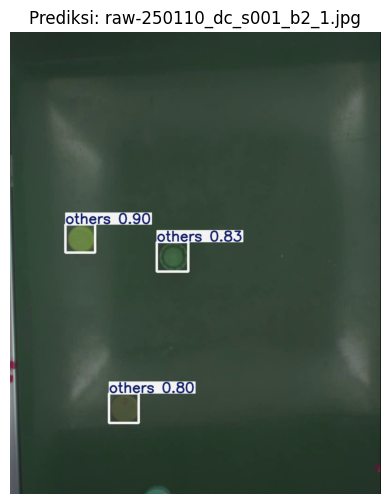


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b2_15.jpg: 320x288 1 light_blue, 8 otherss, 9.0ms
Speed: 1.8ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 288)


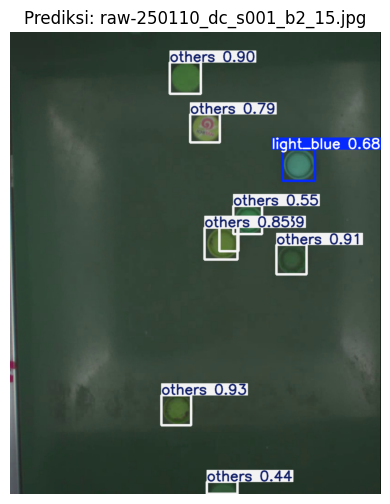


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b2_3.jpg: 320x288 2 light_blues, 5 otherss, 8.3ms
Speed: 1.5ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 288)


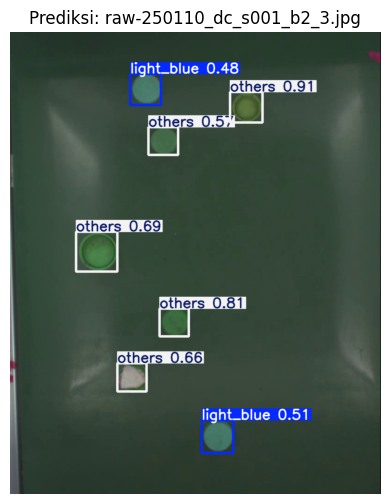


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b3_2.jpg: 320x288 1 dark_blue, 8 otherss, 9.5ms
Speed: 1.4ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 288)


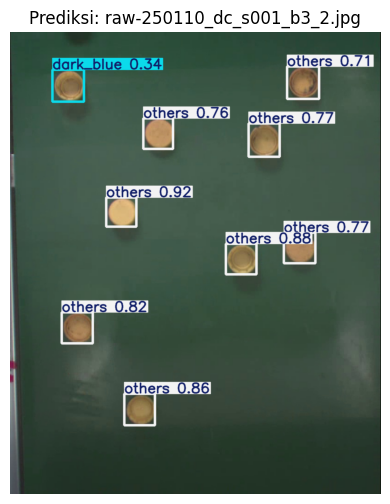


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b3_3.jpg: 320x288 1 dark_blue, 8 otherss, 8.3ms
Speed: 1.3ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 288)


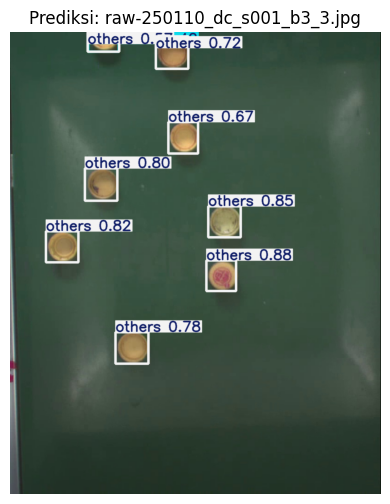


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b3_4.jpg: 320x288 1 dark_blue, 9 otherss, 8.6ms
Speed: 1.5ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 288)


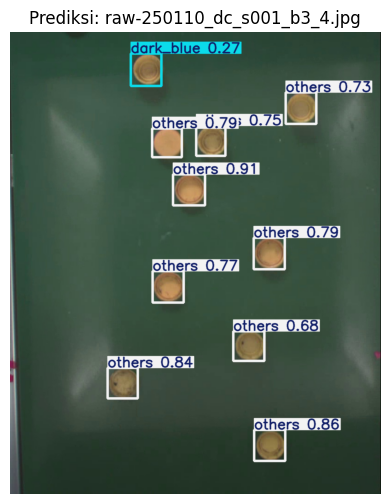


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b4_1.jpg: 320x288 3 light_blues, 2 dark_blues, 8.8ms
Speed: 1.4ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 288)


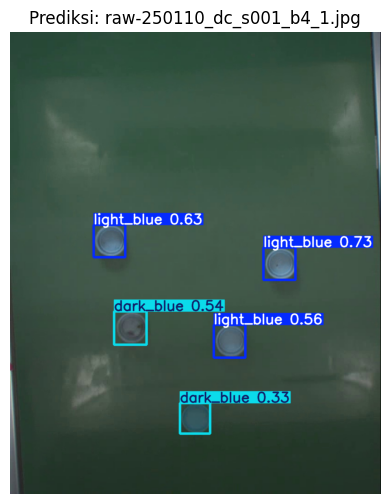


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b4_2.jpg: 320x288 6 light_blues, 1 dark_blue, 10.2ms
Speed: 1.6ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 288)


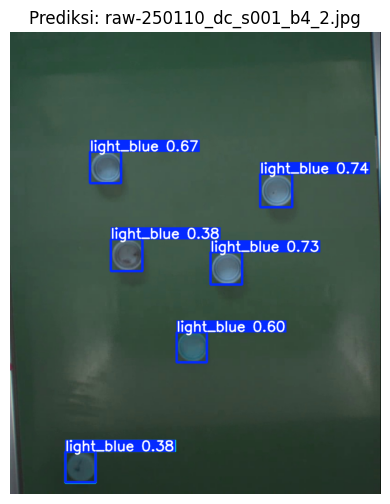


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b4_3.jpg: 320x288 5 light_blues, 2 dark_blues, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 288)


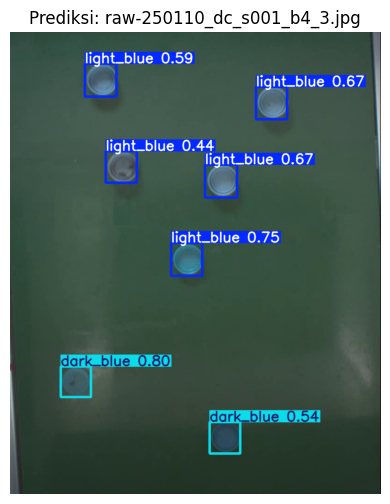


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b5_2.jpg: 320x288 8 dark_blues, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 288)


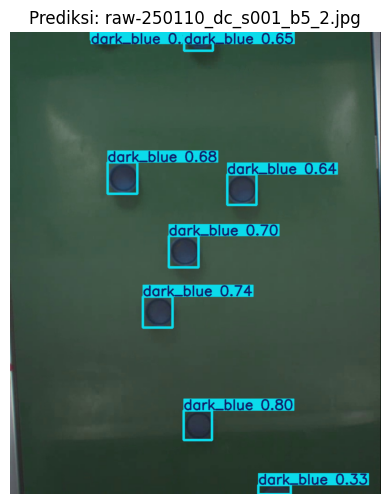

In [9]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

model_path = 'runs/detect/train/weights/best.pt'  # atau train2, train3 dsb
model = YOLO(model_path)

val_dir = Path('/content/yolo_dataset/images')
val_images = sorted(list(val_dir.glob('*.jpg')))

def show_image(img, title=None):
    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

for img_file in val_images[:10]:
    res = model.predict(source=str(img_file), conf=0.25, imgsz=320)
    pred_img = res[0].plot()
    show_image(pred_img, title=f"Prediksi: {img_file.name}")


In [10]:
from pathlib import Path
import cv2
import time
from ultralytics import YOLO

# Load model
model = YOLO('runs/detect/train/weights/best.pt')

# Ambil 1 gambar pertama dari folder
img_folder = Path("/content/yolo_dataset/images")
img_path = sorted(list(img_folder.glob("*.jpg")))[0]   # ambil file pertama

print("Memakai gambar:", img_path.name)
img = cv2.imread(str(img_path))

# Warm-up
model.predict(img, imgsz=320, verbose=False)

times = []
for _ in range(30):
    start = time.time()
    model.predict(img, imgsz=320, verbose=False)
    end = time.time()
    times.append(end - start)

print("Rata-rata:", sum(times)/len(times), "detik")
print("≈", (sum(times)/len(times))*1000, "ms/frame")


Memakai gambar: raw-250110_dc_s001_b2_1.jpg
Rata-rata: 0.007907962799072266 detik
≈ 7.907962799072266 ms/frame
